# Комп'ютерний практикум №1
## Сидорський Володимир Сергійович (КА-21ф)
## Варіант 5

# Завдання

![Task](images/task.png)

# Програма

In [1]:
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt

In [2]:
def is_transitive(matrix):
    n = len(matrix)  # Assuming the matrix is square and non-empty
    
    # Check every combination of i, j, and k
    not_trasitive_list = []
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if matrix[i][k] * matrix[k][j] != matrix[i][j]:
                    not_trasitive_list.append((i + 1,k + 1,j + 1))
    return not_trasitive_list


def plot_hierarchy(levels):
    G = nx.Graph()
    previous_level_nodes = []
    current_level_nodes = []
    position = {}
    y = 0  # initial y-axis position

    # Add the root node
    G.add_node(0)
    position[0] = (0, y)  # Center the root node at (0, y)
    previous_level_nodes.append(0)
    y -= 1

    # Add nodes level by level
    total_nodes = sum(levels) + 1  # Total number of nodes including the root
    horizontal_spacing = max(levels)  # To ensure it is centered

    for i, num_nodes in enumerate(levels, start=1):
        current_level_nodes = []
        offset = (horizontal_spacing - num_nodes) / 2  # Calculate offset to center nodes
        for j in range(num_nodes):
            node_id = sum(levels[:i-1]) + j + 1  # unique node id
            G.add_node(node_id)
            position[node_id] = (j + offset, y)
            current_level_nodes.append(node_id)

            # Connect each node to all nodes in the previous level
            for prev_node in previous_level_nodes:
                G.add_edge(node_id, prev_node)

        previous_level_level_nodes = previous_level_nodes.copy()
        previous_level_nodes = current_level_nodes
        y -= 1

    # Ensure the root node is centered above the first level
    if levels:
        first_level_width = max(levels)
        position[0] = (first_level_width / 2 - 0.5, 0)  # Centering the root node

    # Draw the graph
    nx.draw(G, pos=position, with_labels=False, node_color='skyblue', node_size=500)
    plt.show()

def hierarchy_analyze(
    mpps,
    criteria_weights,
    local_weight_func,
    consistency_func,
    global_weight_func,
):
    mpps = [np.array(el) for el in mpps]
    criteria_weights = np.array(criteria_weights)
    h_structure = [el.shape[1] for el in mpps] + [mpps[-1].shape[0]]
    print(f"m={h_structure}")
    plot_hierarchy(h_structure)
    print("\n"*2)
    cw = criteria_weights.copy()
    for l in range(len(h_structure) - 1):
        # Shape: N Criteria X N Alternatives
        w_local = np.empty(mpps[l].shape[:-1])
        for criteria_idx, mpp in enumerate(mpps[l]):
            not_trasitive_list = is_transitive(mpp)
            print(f"Досліджуємо МПП рівня {l+2}, критерія {criteria_idx + 1}")
            print(mpp)
            if len(not_trasitive_list) == 0:
                print("Матриця узгоджена за означенням")
            else:
                # nte stands for not_trasitive_element
                nte = not_trasitive_list[0]
                print(f"Матриця не узгоджена, бо: d{nte[0]}{nte[1]}*d{nte[1]}{nte[2]} != d{nte[0]}{nte[2]}")
            w_local_mpp, add_outputs = local_weight_func(mpp)
            print(f"Локальні ваги: {w_local_mpp}")
            w_local[criteria_idx] = w_local_mpp
            consistency_func(mpp, **add_outputs)
            print("="*10)
        w_global = global_weight_func(w_local, cw)
        print(f"Глобальні ваги для рівня {l+2}: {w_global}")
        cw = w_global.copy()
        print("\n"*2)
    print("Ранжування альтернатив (від кращого до гіршого): ", ["a"+str(idx) for idx in np.argsort(-w_global) + 1])

In [3]:
def rgmm(D):
    w = np.prod(D, axis=1) ** (1/D.shape[0])
    return w / w.sum(), {"or_w": w}

def compute_gci(D, or_w):
    n = D.shape[0]
    gci = 0
    # Sum only elements where i < j
    for i in range(n):
        for j in range(i + 1, n):
            gci += (np.log(D[i][j]) - np.log(or_w[i] / or_w[j])) ** 2
            
    gci *= (2 / (n -1) * (n-2))

    # Matrix dims: 0, 1, 2, 3, 4, 5
    THRESHS = [0, 0, 0, 0.1573, 0.3526, 0.370]
    thresh = THRESHS[n]

    if gci > thresh:
        print(f"GCI(={gci:.3f}) > {thresh} - МПП неузгоджена")
    elif gci > 0:
        print(f"GCI(={gci:.3f}) <= {thresh} - МПП допустимо узгоджена")
    else:
        print(f"GCI = 0.0 - МПП узгоджена")
    

def distributive_method(w_local, cw):
    w_local /= w_local.sum(0)
    return w_local @ cw

# Виклик програми

# Вхідні данні

Вхідні данні у форматі `.json`. Необхідно задати:

- МПП для кожного рівня
- Ваги критеріїв 

In [4]:
INPUT = {
    "mpps":[
        [
            [[1, 2],
             [1/2, 1]],
            [[1, 3],
             [1/3, 1]],
            [[1, 4],
             [1/4, 1]],
            [[1, 5],
             [1/5, 1]]
        ],
        [
            [[1, 3, 1/3, 2],
             [1/3, 1, 1/4, 1/2],
             [3, 4, 1, 6],
             [1/2, 2, 1/6, 1]],
            [[1, 1/5, 2.5, 4],
             [5, 1, 3, 1/2],
             [1/2.5, 1/3, 1, 1/4],
             [1/4, 2, 4, 1]],
            [[1, 2, 5, 1/2],
             [1/2, 1, 3, 1/4],
             [1/5, 1/3, 1, 1/5],
             [2, 4, 5, 1]],
            [[1, 1/2, 4, 3],
             [2, 1, 2, 2.5],
             [1/4, 1/2, 1, 1/3],
             [1/3, 1/2.5, 3, 1]]
        ]
    ],
    "criteria_weights": [0.3, 0.7]
}

## Виклик програми

З заданими вхідними даними. Реалізована через необхідні алгоритми

m=[2, 4, 4]


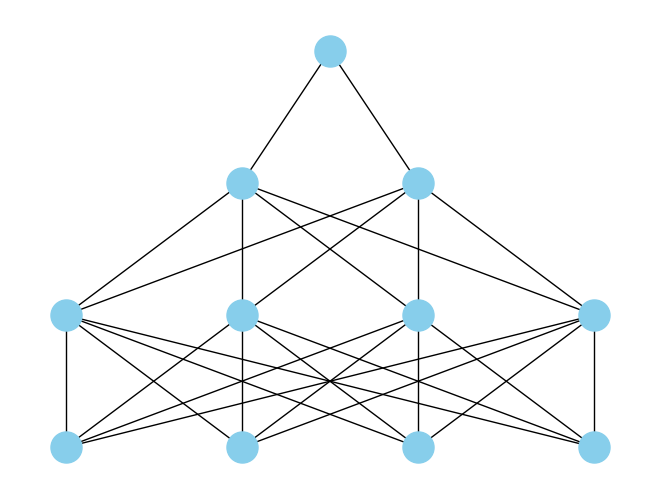




Досліджуємо МПП рівня 2, критерія 1
[[1.  2. ]
 [0.5 1. ]]
Матриця узгоджена за означенням
Локальні ваги: [0.66666667 0.33333333]
GCI = 0.0 - МПП узгоджена
Досліджуємо МПП рівня 2, критерія 2
[[1.         3.        ]
 [0.33333333 1.        ]]
Матриця узгоджена за означенням
Локальні ваги: [0.75 0.25]
GCI = 0.0 - МПП узгоджена
Досліджуємо МПП рівня 2, критерія 3
[[1.   4.  ]
 [0.25 1.  ]]
Матриця узгоджена за означенням
Локальні ваги: [0.8 0.2]
GCI = 0.0 - МПП узгоджена
Досліджуємо МПП рівня 2, критерія 4
[[1.  5. ]
 [0.2 1. ]]
Матриця узгоджена за означенням
Локальні ваги: [0.83333333 0.16666667]
GCI = 0.0 - МПП узгоджена
Глобальні ваги для рівня 2: [0.31118781 0.25798102 0.22605695 0.20477423]



Досліджуємо МПП рівня 3, критерія 1
[[1.         3.         0.33333333 2.        ]
 [0.33333333 1.         0.25       0.5       ]
 [3.         4.         1.         6.        ]
 [0.5        2.         0.16666667 1.        ]]
Матриця не узгоджена, бо: d13*d32 != d12
Локальні ваги: [0.229006

In [5]:
hierarchy_analyze(
    **INPUT,
    local_weight_func=rgmm,
    consistency_func=compute_gci,
    global_weight_func=distributive_method,
)

# Висновки

В цій роботі було вивчено методи парних порівнянь розрахунку ваг альтернатив рішень відносно спільного критерію, вивчено етапи базового методу аналізу ієрархій розрахунку ваг альтернатив рішень за множиною незалежних критеріїв. Локальні ваги обчислені за допомогою Метода геометричної середньої (RGMM), узгодженість досліджена за допомогою Геометричного індекса узгодженості (GCI), а глобальні ваги альтернатив рішень для задачі ППР обчислено за допомогою дистрибутивного методу. Також побудований граф ієрархії. Зауважимо також, що основна ф-ція `hierarchy_analyze` реалізована з використанням парадигми функціонального програмування, що уможливлює зручну заміну методів для обчислення локальних ваг (`local_weight_func`), критерія узгодженості (`consistency_func`) і глобальних ваг (`global_weight_func`). Результати та текст програми наведено у звіті. 